In [2]:
import os
import math
import gzip
import pickle
from random import gauss
from itertools import product
from time import sleep
from datetime import datetime, timedelta, date
from urllib import request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib

from tqdm.notebook import tqdm

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

%matplotlib inline

### データの準備

In [3]:
with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    df = pickle.load(f)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


In [4]:
FREQ='15min'
time_bar = pd.DataFrame(columns=['op', 'hi', 'lo', 'cl', 'volume'])
time_bar.index.name = "timestamp"

ohlc = df["price"].resample(FREQ).ohlc()
volume = df["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo", "cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


### 特徴量の作成、指定

In [5]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [6]:
calc_features(time_bar)

time_bar.to_pickle("df_features.pkl")
display(time_bar)

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174,169.260682,-29.1,-227.460682,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,99.180341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31 22:45:00,45690.5,45800.0,45690.0,45786.0,7734788,73.42218,1.5,-70.42218,-168.148479,193.325447,...,0.995107,0.633786,0,0.383537,0.815266,8.0,84.732303,-133.0,10.846154,35.961090
2022-03-31 23:00:00,45780.5,45780.5,45650.0,45680.5,7040102,107.737695,18.35,-71.037695,-147.272226,206.441547,...,0.707763,0.000929,0,0.857388,0.730189,86.014286,80.261024,10.271429,5.826374,44.693847
2022-03-31 23:15:00,45680.0,45684.5,45589.0,45681.5,13943959,186.497663,87.55,-11.397663,-75.944683,269.445318,...,0.065495,-0.659277,0,0.534208,0.550943,52.8,-8.930590,54.842857,-0.157143,49.473831


In [7]:
#以下のコードでは学習に使う特徴量カラムを指定する。
features =sorted([
    
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


### ラベリング方法での比較

##### opとclの大小比較による0か1でのラベリング

In [8]:
# 目的変数の作成
y = time_bar.cl / time_bar.op
y = y.apply(lambda x: 1 if x > 1 else 0)

time_bar["target"] = y
time_bar.dropna(inplace=True)

time_bar.to_pickle('df_target.pkl')

In [9]:
time_bar.head()

,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-01 22:00:00,43868.0,43868.0,43774.0,43840.0,4127124,222.605745,70.3,-82.005745,72.536391,-9.417522,...,-0.362494,0,0.522806,0.862698,83.157143,82.122515,-10.8,7.227473,76.152873,0
2022-03-01 22:15:00,43840.0,43960.0,43840.0,43945.5,6538919,142.120738,-9.3,-160.720738,4.971313,-79.777682,...,-0.557421,0,0.809185,0.866785,-13.185714,82.101170,-106.885714,7.207692,75.710369,1
2022-03-01 22:30:00,43945.5,44169.5,43939.5,44150.0,17811845,115.528242,-135.0,-385.528242,-113.817049,-213.001702,...,-0.689043,0,0.327546,0.890181,-173.871429,83.782552,-293.2,9.179121,125.264121,1
2022-03-01 22:45:00,44150.0,44231.0,44058.5,44158.0,9410449,120.633162,-152.55,-425.733162,-170.944514,-282.832238,...,-0.758299,0,0.417686,0.901287,-114.042857,86.710757,-340.242857,17.400000,136.591581,1
2022-03-01 23:00:00,44158.0,44262.5,44078.0,44125.5,7828911,129.975116,-126.45,-382.875116,-170.749582,-291.326932,...,-0.749985,0,0.352744,0.917209,-42.685714,87.190608,-307.6,20.378022,128.212558,0


##### returnによるラベリング

<AxesSubplot:title={'center':'毎時刻、targetが1のときだけトレードした場合の累積リターン'}, xlabel='timestamp'>

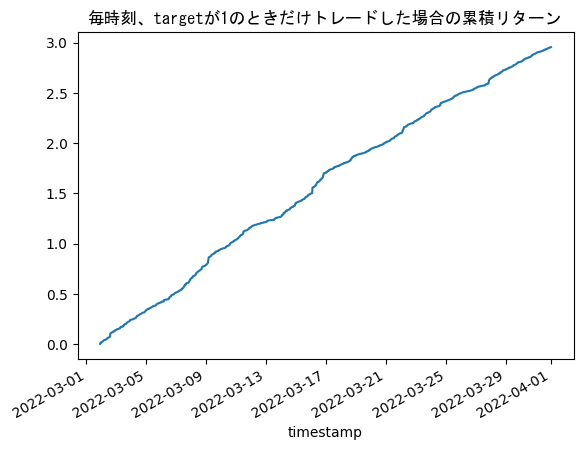

In [10]:
df = pd.read_pickle('df_target.pkl')
ret = df['op'].copy()

for i in range(df["op"].values.size):
    ret[i] = df["cl"][i]/df["op"][i] -1
    
df['ret'] = ret

df.to_pickle('df_y.pkl')

plt.title('毎時刻、targetが1のときだけトレードした場合の累積リターン', fontname="MS Gothic")
df['ret'][df['target'] >0].cumsum().plot(label='買い')

In [11]:
df = pd.read_pickle('df_y.pkl')
df.dropna()

model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
cv_indicies = list(KFold().split(df))

def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    
    for train_idex, val_idx in cv:
        estimator.fit(X[train_idex], y[train_idex])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred



毎時刻、ret_predがプラスの時だけリターンした場合の累積リターン


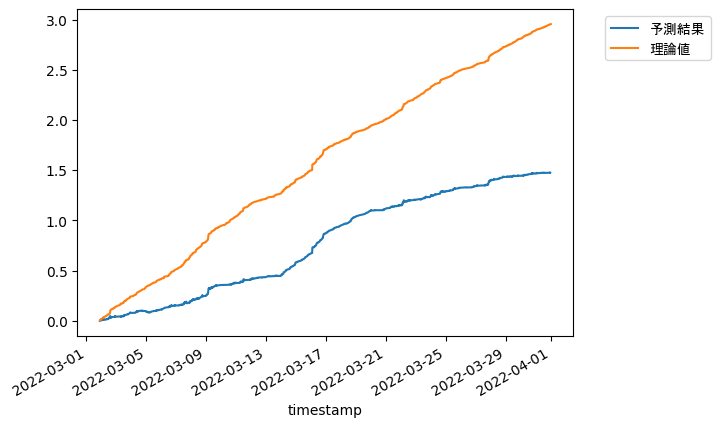

In [12]:
#　retを予測
df['ret_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)

#　毎時刻ret>0のときのみトレード
print('毎時刻、ret_predがプラスの時だけリターンした場合の累積リターン')
df['ret'][df['ret_pred']>0].cumsum().plot(label='予測結果')
df['ret'][df['ret']>0].cumsum().plot(label='理論値')
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"MS Gothic"})


毎時刻、target_predがプラスの時だけリターンした場合の累積リターン


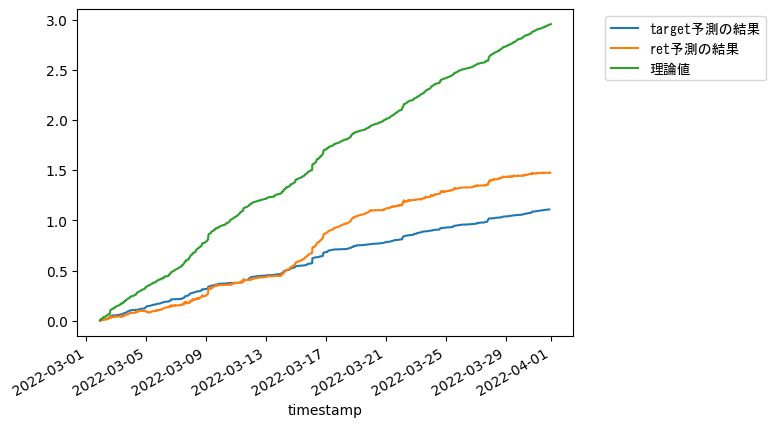

In [13]:
#　targetを予測(比較用にretの予測も)
df['target_pred'] = my_cross_val_predict(model, df[features].values, df['target'].values, cv_indicies)
df['ret_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)


#　毎時刻target>0のときのみトレード
print('毎時刻、target_predがプラスの時だけリターンした場合の累積リターン')
df['ret'][df['target_pred']>0].cumsum().plot(label='target予測の結果')
df['ret'][df['ret_pred']>0].cumsum().plot(label='ret予測の結果')

df['ret'][df['ret']>0].cumsum().plot(label='理論値')
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"MS Gothic"})

### モデルによる比較

In [17]:
df = pd.read_pickle('df_y.pkl')
df.dropna()

# モデル
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))


# アンサンブル
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

cv_indicies = list(KFold().split(df))

def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    
    for train_idex, val_idx in cv:
        estimator.fit(X[train_idex], y[train_idex])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred




In [22]:
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
df['LGBM_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)

model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
df['Ridge_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)

model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model = BaggingRegressor(model, random_state=1, n_jobs=1)
df['LGBM_ensemble_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)

model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = BaggingRegressor(model, random_state=1, n_jobs=1)
df['Ridge_ensemble_pred'] = my_cross_val_predict(model, df[features].values, df['ret'].values, cv_indicies)

df.to_pickle('df_models.pkl')

毎時刻ret_predがプラスだった時の累積リターンのモデル事の比較


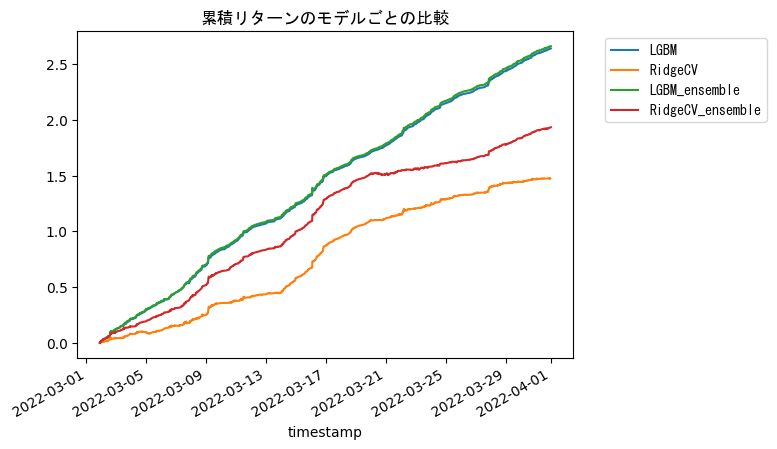

In [25]:
df = pd.read_pickle('df_models.pkl')

print('毎時刻ret_predがプラスだった時の累積リターンのモデル事の比較')
df['ret'][df['LGBM_pred'] > 0].cumsum().plot(label='LGBM')
df['ret'][df['Ridge_pred'] > 0].cumsum().plot(label='RidgeCV')
df['ret'][df['LGBM_ensemble_pred'] > 0].cumsum().plot(label='LGBM_ensemble')
df['ret'][df['Ridge_ensemble_pred'] > 0].cumsum().plot(label='RidgeCV_ensemble')

plt.title('累積リターンのモデルごとの比較',  fontname="MS Gothic")
plt.legend(bbox_to_anchor=(1.05, 1), prop={"family":"MS Gothic"})


